https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/04/laplace_approx_beta_binom_jax.ipynb

In [1]:
import jax
import jax.numpy as jnp 
from jax import lax 

from tensorflow_probability.substrates import jax as tfp  # pip install tensorflow-probability
dist = tfp.distributions 
import optax 

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]


Find $\hat\theta_{MAP}$ by minimizing negative log prior-likelihood (joint)

In [3]:
# prior distribution ~ Beta
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)

# likelihood distribution ~ Bernoulli
def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

def neg_log_prior_likelihood_fn(params, dataset):
    theta = params["theta"]
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()  # log probability of likelihood
    prior_log_prob = prior_dist().log_prob(theta)  # log probability of prior
    return -(likelihood_log_prob + prior_log_prob)  # negative log_prior_liklihood

In [4]:
loss_and_grad_fn = jax.value_and_grad(neg_log_prior_likelihood_fn)
params = {"theta": 0.5}
neg_joint_log_prob, grads = loss_and_grad_fn(params, dataset)

optimizer = optax.adam(0.01)
opt_state = optimizer.init(params)

In [5]:
@jax.jit
def train_step(carry, data_output):

    params = carry["params"]
    neg_joint_log_prob, grads = loss_and_grad_fn(params, dataset)

    opt_state = carry["opt_state"]
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    carry = {"params": params, "opt_state": opt_state}
    data_output = {"params": params, "loss": neg_joint_log_prob}

    return carry, data_output

In [6]:
carry = {"params": params, "opt_state": opt_state}
data_output = {"params": params, "loss": neg_joint_log_prob}

n = 100
iterator = jnp.ones(n)
last_carry, output = jax.lax.scan(train_step, carry, iterator)

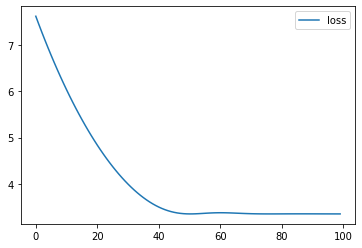

In [7]:
loss = output["loss"]
plt.plot(loss, label="loss")
plt.legend();

In [8]:
optimized_params = last_carry["params"]
theta_map = optimized_params["theta"]
print(f"theta_map = {theta_map}")

theta_map = 0.09168018400669098


In [9]:
loc = theta_map  # loc of approximate posterior
print(f"loc = {loc}")
# scale of approximate posterior
scale = 1 / jnp.sqrt(jax.hessian(neg_log_prior_likelihood_fn)(optimized_params, dataset)["theta"]["theta"])
print(f"scale = {scale}")

loc = 0.09168018400669098
scale = 0.08733917027711868


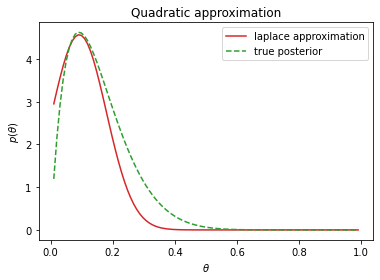

In [10]:
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)
theta_range = jnp.linspace(0.01, 0.99, 100)
y = jnp.exp(dist.Normal(loc, scale).log_prob(theta_range))

plt.figure()
plt.title("Quadratic approximation")
plt.plot(theta_range, y, label="laplace approximation", color="tab:red")
plt.plot(theta_range, exact_posterior.prob(theta_range), label="true posterior", color="tab:green", linestyle="--")
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta)$")
plt.legend();

# Laplace Approx with pymc3 / numpyro / pyro

In [13]:
import pymc3 as pm 
import scipy.stats as stats 

# Laplace
with pm.Model() as normal_aproximation:
    theta = pm.Beta("theta", 1.0, 1.0)
    y = pm.Binomial("y", n=1, p=theta, observed=dataset)  # Bernoulli
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[theta])) ** 0.5)[0]
    loc = mean_q["theta"]

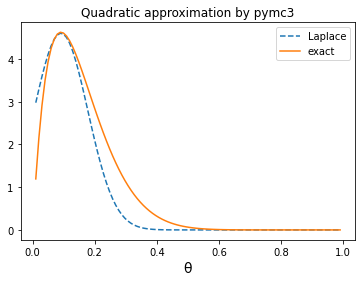

In [17]:
x = theta_range

plt.figure()
plt.plot(x, stats.norm.pdf(x, loc, std_q), "--", label="Laplace")
post_exact = stats.beta.pdf(x, n_heads + 1, n_tails + 1)
plt.plot(x, post_exact, label="exact")
plt.title("Quadratic approximation by pymc3")
plt.xlabel("θ", fontsize=14)
plt.legend();